##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras 전처리 레이어를 사용한 구조적 데이터 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 CSV 파일로 저장된 <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">Kaggle 대회의 PetFinder 데이터세트</a>의 간소화된 버전을 사용하여 표로 나타낸 데이터와 같은 구조적 데이터를 분류하는 방법을 보여줍니다.

[Keras](https://www.tensorflow.org/guide/keras)를 사용하여 모델을 정의하고, CSV 파일의 열에서 모델을 훈련하는 데 사용되는 특성으로 매핑하는 다리로 [Keras 전처리 레이어](https://www.tensorflow.org/guide/keras/preprocessing_layers)를 사용합니다. 목표는 애완 동물이 입양되는지 예측하는 것입니다.

이 튜토리얼에는 다음을 위한 완전한 코드가 포함되어 있습니다.

- <a href="https://pandas.pydata.org/" class="external">pandas</a>를 사용하여 CSV 파일을 <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a>에 로드.
- `tf.data`를 사용하여 행을 일괄 처리하고 순서를 섞는 입력 파이프라인 빌드(자세한 내용은 [tf.data: Build TensorFlow 입력 파이프라인](../../guide/data.ipynb)을 방문).
- Keras 전처리 레이어를 사용하여 CSV의 열에서 모델을 훈련하는 데 사용되는 특성으로 매핑.
- Keras의 내장 메서드를 사용하여 모델을 빌드, 훈련, 평가.

참고: 이 튜토리얼은 [특성 열의 구조적 데이터 분류하기](../structured_data/feature_columns.ipynb)와 유사합니다. 이 버전은 `tf.feature_column` API 대신 [Keras 전처리 레이어](https://www.tensorflow.org/guide/keras/preprocessing_layers)를 사용합니다. 전자가 더 직관적이며 배포를 단순화하기 위해 모델 내에 쉽게 포함될 수 있기 때문입니다.

## PetFinder.my mini 데이터세트

PetFinder.my mini의 CSV 데이터세트 파일에는 수천 개의 행이 있으며 각 행은 애완 동물(개 또는 고양이)을 설명하고 각 열은 나이, 품종, 색상 등과 같은 속성을 설명합니다.

아래 데이터세트의 요약을 통해 대부분 숫자 및 범주형 열로 이루어져 있음을 알 수 있습니다. 이 튜토리얼에서는 데이터를 전처리하는 동안 `Description`(자유 텍스트 특성) 및 `AdoptionSpeed`(분류 특성)를 낮추는 두 가지 기능 유형만 다룰 것입니다.

열 | 애완 동물 설명 | 특성 유형 | 데이터 형식
--- | --- | --- | ---
`유형` | 동물의 종류(개, 고양이) | 범주형 | 문자열
`Age` | 나이 | 수치 | 정수
`품종 1` | 기본 품종 | 범주형 | 문자열
`Color1` | 색상 1 | 범주형 | 문자열
`Color2` | 색상 2 | 범주형 | 문자열
`MaturitySize` | 성장한 크기 | 범주형 | 문자열
`FurLength` | 모피 길이 | 범주형 | 문자열
`예방 접종` | 애완 동물이 예방 접종을 받았습니다 | 범주형 | 문자열
`불임 시술` | 애완 동물이 불임 시술을 받았습니다 | 범주형 | 문자열
`건강` | 건강 상태 | 범주형 | 문자열
`회비` | 입양비 | 수치 | 정수
`설명` | 프로필 작성 | 텍스트 | 문자열
`PhotoAmt` | 업로드된 총 사진 | 수치 | 문자열
`AdoptionSpeed` | 입양 속도(범주형) | 분류 | 문자열

## TensorFlow 및 기타 라이브러리 가져오기


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

2022-12-14 23:21:31.042474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:21:31.042605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 23:21:31.042617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
tf.__version__

'2.11.0'

## 데이터세트 로드 및 pandas DataFrame으로 읽어오기

<a href="https://pandas.pydata.org/" class="external">pandas</a>는 구조적 데이터를 로드하고 처리하는 데 유용한 여러 유틸리티가 포함된 Python 라이브러리입니다. `tf.keras.utils.get_file`을 사용하여 PetFinder.my 미니 데이터세트가 포함된 CSV 파일을 다운로드 및 추출하고 <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html" class="external"><code>pandas.read_csv</code></a>를 사용하여 <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a>에 로드합니다.

In [4]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

   8192/1668792 [..............................] - ETA: 0s

1668792/1668792 [==============================] - 0s 0us/step


DataFrame의 처음 5개 행을 확인하여 데이터세트를 검사합니다.

In [5]:
dataframe.head()

Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  \
0     Short         No         No  Healthy  100   
1    Medium   Not Sure   Not Sure  Healthy    0   
2    Medium        Yes         No  Healthy    0   
3     Short        Yes         No  Healthy  150   
4     Short         No         No  Healthy    0   

                                         Description  PhotoAmt  AdoptionSpeed  
0  Nibble is a 3+ month old ball of cuteness. He ...         1              2  
1  I just found it alone yesterday near my apartm...         2              0  
2  Their pregnant mother was dumped by her irresp...         7              3  
3  Good guard dog, very alert, active, obedience ...         8              2  
4  This handsome yet cute boy is up for adoption....         3              2

## 목표 변수 만들기

Kaggle의 <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder.my 입양 예측 대회</a>의 원래 작업 목표는 애완동물이 입양되는 속도를 예측하는 것이었습니다(예: 첫번째 주, 첫번째 달, 처음 3개월 등).

이 튜토리얼에서는 작업을 단순화하여 애완 동물이 입양되었는지 여부를 단순하게 예측해야 하는 이진 분류 문제로 변환합니다.

`AdoptionSpeed` 열을 수정한 후, `0`은 애완 동물이 입양되지 않았음을 나타내고 `1`은 입양되었음을 나타냅니다.

In [6]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## DataFrame을 훈련, 검증 및 테스트로 분할하기

훈련, 검증 및 테스트로 분할할 경우, 예를 들면 각각 80:10:10의 비율의 테스트 세트로 분할합니다.

In [7]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [8]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


## tf.data를 사용하여 입력 파이프라인 만들기

다음으로 각 훈련, 검증 및 테스트 세트 DataFrame을 `tf.data.Dataset`로 변환한 다음 데이터를 무작위로 섞고 일괄 처리하는 유틸리티 함수를 생성합니다.

참고: 매우 큰 CSV 파일(메모리에 적합하지 않을 정도로 큰 파일)을 사용하는 경우, `tf.data`를 사용하여 디스크에서 직접 읽을 수 있습니다. 이 튜토리얼에서는 다루지 않습니다.

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

이제 새로 생성된 함수(`df_to_dataset`)를 사용하여 입력 파이프라인 도우미 함수가 훈련 데이터에서 호출하여 반환하는 데이터 형식을 확인하고, 작은 배치 크기를 사용하여 출력을 읽을 수 있도록 유지합니다.

In [10]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/tmpfs/tmp/ipykernel_775031/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [11]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[3]
 [7]
 [3]
 [5]
 [1]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 0 1 1 0], shape=(5,), dtype=int64)


출력에서 확인할 수 있듯이 훈련 세트는 행에서 열 값으로 매핑되는 열 이름의 사전(DataFrame에서)을 반환합니다.

## Keras 전처리 레이어 적용하기

Keras 전처리 레이어를 사용하여 Keras 네이티브 입력 처리 파이프라인을 빌드할 수 있습니다. 이러한 입력 처리 파이프라인은 Keras가 아닌 워크플로에서 독립적인 전처리 코드로 사용할 수 있고, Keras 모델과 직접 결합하고, Keras SavedModel의 일부로 내보낼 수 있습니다.

이 튜토리얼에서는 다음 네 가지 전처리 레이어를 사용하여 전처리, 구조적 데이터 인코딩 및 특성 엔지니어링을 수행하는 방법을 보여 줍니다.

- `tf.keras.layers.Normalization`: 입력 기능의 기능별 정규화를 수행합니다.
- `tf.keras.layers.CategoryEncoding`: 정수 범주형 기능을 원-핫(one-hot), 멀티-핫(multi-hot) 또는 <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" class="external">tf-idf</a> 밀집 표현(dense representations)으로 바꿉니다.
- `tf.keras.layers.StringLookup`: 문자열 범주형 값을 정수 인덱스로 바꿉니다.
- `tf.keras.layers.IntegerLookup`: 정수 범주형 값을 정수 인덱스로 바꿉니다.

[전처리 레이어 처리](https://www.tensorflow.org/guide/keras/preprocessing_layers) 가이드에서 사용 가능한 레이어에 대해 자세히 알아볼 수 있습니다.

- PetFinder.my mini 데이터세트의 *숫자 특성*의 경우 `tf.keras.layers.Normalization` 레이어를 사용하여 데이터 분포를 표준화합니다.
- 애완 동물 `Type`(`Dog` 및 `Cat` 문자열)과 같은 *범주형 특성*의 경우 `tf.keras.layers.CategoryEncoding`을 사용하여 멀티-핫 인코딩된 텐서로 변환합니다.

### 숫자 열

PetFinder.my mini 데이터세트의 각 <em>숫자 특성</em>의 경우 `tf.keras.layers.Normalization` 레이어를 사용하여 데이터 분포를 표준화합니다.

Keras 전처리 레이어 사용하여 다음과 같이 숫자 특성에 특성별 정규화를 적용하는 레이어를 반환하는 새로운 유틸리티 함수를 정의합니다.

In [12]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

다음으로 업로드된 전체 애완 동물 사진 특성에서 호출하는 방식으로 새 함수를 테스트하여 `'PhotoAmt'`를 정규화합니다.

In [13]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.7534282 ],
       [ 6.423487  ],
       [-0.19158155],
       [-0.5065848 ],
       [-0.8215881 ]], dtype=float32)>

참고: 숫자 특성이 많은 경우(수백 개 이상) 먼저 숫자 특성을 연결하고 단일 `tf.keras.layers.Normalization` 레이어를 사용하는 것이 더 효율적입니다.

### 범주 열

데이터세트의 애완 동물 `Type`은 문자열 `Dog` 및 `Cat`으로 표시되며, 모델에 공급되기 전에 멀티-핫 인코딩되어야 합니다. `Age` 특성

`tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup` 및 `tf.keras.CategoryEncoding` 전처리 레이어를 사용하여 어휘의 값을 정수 인덱스로 매핑하고 특성을 멀티-핫 인코딩하는 레이어를 반환하는 또 다른 새 유틸리티 함수를 정의합니다.

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

애완 동물 `'Type'` 특성에서 `get_category_encoding_layer` 함수를 호출하고 멀티-핫 인코딩된 텐서로 변환하여 테스트합니다.

In [15]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

애완 동물 `'Age'` 특성에 대해 프로세스를 반복합니다.

In [16]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

## 모델을 훈련하기 위해 선택한 특성 전처리하기

여러분은 여러 유형의 Keras 전처리 레이어를 사용하는 방법을 배웠습니다. 다음으로 여러분은,

- PetFinder.my mini 데이터세트의 13가지 숫자 및 범주 특성에 대해 앞서 정의한 전처리 유틸리티 기능을 적용합니다.
- 모든 특성 입력을 목록에 추가합니다.

시작에서 언급했듯이 모델을 훈련하기 위해 PetFinder.my mini 데이터세트의 숫자(`'PhotoAmt'`, `'Fee'`) 및 범주(`'Age'`, `'Type'`, `'Color1'`, `'Color2'`, `'Gender'`, `'MaturitySize'`, `'FurLength'`, `'Vaccinated'`, `'Sterilized'`, `'Health'`, `'Breed1'`) 특성을 사용합니다.

참조: 목표가 정확한 모델을 빌드하는 것이라면 자신의 더 큰 데이터세트를 시도하고 포함할 가장 의미 있는 특성과 표현 방법에 대해 신중하게 고려하세요.

이전에는 입력 파이프라인을 보여주기 위해 작은 배치 크기를 사용했습니다. 이제 더 큰 배치 크기(256)로 새 입력 파이프라인을 생성해 보겠습니다.

In [17]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmpfs/tmp/ipykernel_775031/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmpfs/tmp/ipykernel_775031/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmpfs/tmp/ipykernel_775031/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


숫자 특성(애완 동물 사진 수 및 입양비)을 정규화하고 정규화한 숫자 특성을 `encoded_features`라고 부르는 하나의 입력 목록에 추가합니다.

In [18]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

데이터세트(애완 동물 나이)의 정수 범주형 값을 정수 인덱스로 변환하고, 멀티-핫 인코딩을 수행하고, 결과 특성 입력을 `encoded_features`에 추가합니다.

In [19]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

문자열 범주형 값에 대해 동일한 단계를 반복합니다.

In [20]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

## 모델 생성, 컴파일 및 훈련하기


다음 단계는 [Keras 기능적 API](https://www.tensorflow.org/guide/keras/functional)를 사용하여 모델을 생성하는 것입니다. 모델의 첫 번째 레이어의 경우 특성 입력 목록인 `encoded_features`와 `tf.keras.layers.concatenate`의 연결을 통해 하나의 벡터로 병합합니다.

In [21]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

Keras `Model.compile`로 모델 구성하기:

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

연결 그래프를 시각화해 보겠습니다.


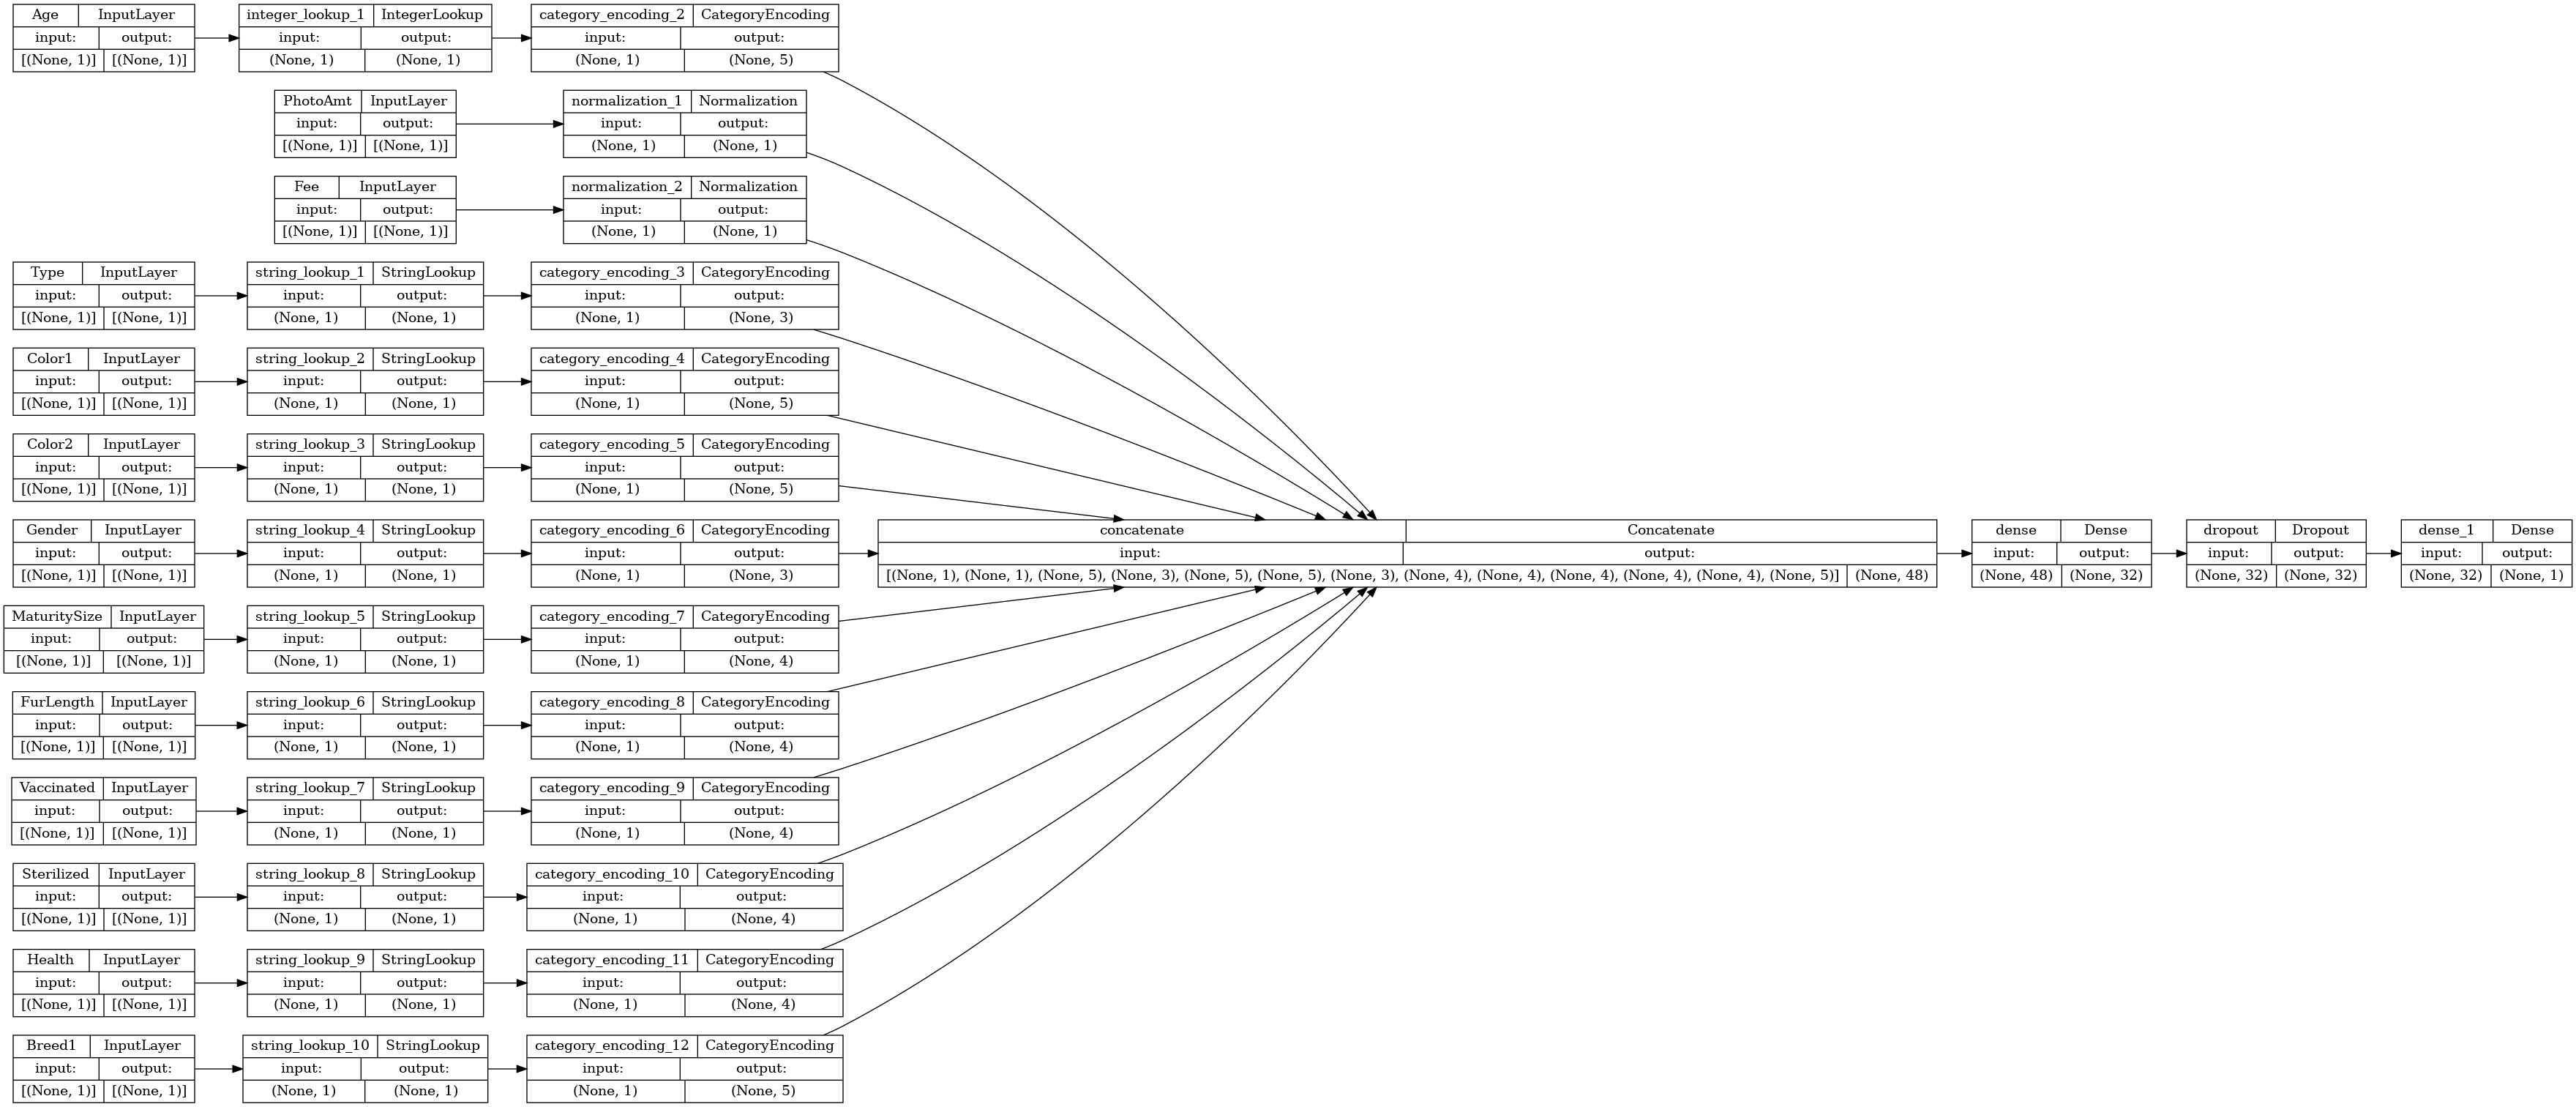

In [23]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

다음으로, 모델을 훈련하고 테스트합니다.

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/37 [..............................] - ETA: 1:17 - loss: 0.8831 - accuracy: 0.2266

 9/37 [======>.......................] - ETA: 0s - loss: 0.8077 - accuracy: 0.2708  

17/37 [============>.................] - ETA: 0s - loss: 0.7799 - accuracy: 0.2732

25/37 [===================>..........] - ETA: 0s - loss: 0.7507 - accuracy: 0.2892

33/37 [=========================>....] - ETA: 0s - loss: 0.7267 - accuracy: 0.3125

37/37 [==============================] - 3s 21ms/step - loss: 0.7197 - accuracy: 0.3228 - val_loss: 0.6172 - val_accuracy: 0.5078


Epoch 2/10


 1/37 [..............................] - ETA: 2s - loss: 0.6088 - accuracy: 0.4922

 9/37 [======>.......................] - ETA: 0s - loss: 0.6110 - accuracy: 0.5139

17/37 [============>.................] - ETA: 0s - loss: 0.6052 - accuracy: 0.5393

25/37 [===================>..........] - ETA: 0s - loss: 0.6051 - accuracy: 0.5591

33/37 [=========================>....] - ETA: 0s - loss: 0.5989 - accuracy: 0.5801

37/37 [==============================] - 0s 8ms/step - loss: 0.5970 - accuracy: 0.5875 - val_loss: 0.5807 - val_accuracy: 0.6941


Epoch 3/10


 1/37 [..............................] - ETA: 2s - loss: 0.5924 - accuracy: 0.6641

 8/37 [=====>........................] - ETA: 0s - loss: 0.5877 - accuracy: 0.6738

16/37 [===========>..................] - ETA: 0s - loss: 0.5785 - accuracy: 0.6721

24/37 [==================>...........] - ETA: 0s - loss: 0.5792 - accuracy: 0.6712

33/37 [=========================>....] - ETA: 0s - loss: 0.5776 - accuracy: 0.6699

37/37 [==============================] - 0s 8ms/step - loss: 0.5761 - accuracy: 0.6721 - val_loss: 0.5660 - val_accuracy: 0.7218


Epoch 4/10


 1/37 [..............................] - ETA: 2s - loss: 0.6012 - accuracy: 0.6836

 9/37 [======>.......................] - ETA: 0s - loss: 0.5766 - accuracy: 0.6866

17/37 [============>.................] - ETA: 0s - loss: 0.5681 - accuracy: 0.6808

25/37 [===================>..........] - ETA: 0s - loss: 0.5607 - accuracy: 0.6858

33/37 [=========================>....] - ETA: 0s - loss: 0.5647 - accuracy: 0.6851

37/37 [==============================] - 0s 8ms/step - loss: 0.5645 - accuracy: 0.6873 - val_loss: 0.5552 - val_accuracy: 0.7496


Epoch 5/10


 1/37 [..............................] - ETA: 2s - loss: 0.5934 - accuracy: 0.6602

 9/37 [======>.......................] - ETA: 0s - loss: 0.5579 - accuracy: 0.6984

17/37 [============>.................] - ETA: 0s - loss: 0.5567 - accuracy: 0.6958

25/37 [===================>..........] - ETA: 0s - loss: 0.5557 - accuracy: 0.6997

33/37 [=========================>....] - ETA: 0s - loss: 0.5526 - accuracy: 0.7002

37/37 [==============================] - 0s 8ms/step - loss: 0.5512 - accuracy: 0.7009 - val_loss: 0.5462 - val_accuracy: 0.7530


Epoch 6/10


 1/37 [..............................] - ETA: 2s - loss: 0.5272 - accuracy: 0.7383

 9/37 [======>.......................] - ETA: 0s - loss: 0.5459 - accuracy: 0.7109

18/37 [=============>................] - ETA: 0s - loss: 0.5518 - accuracy: 0.7075

27/37 [====================>.........] - ETA: 0s - loss: 0.5448 - accuracy: 0.7138

36/37 [============================>.] - ETA: 0s - loss: 0.5447 - accuracy: 0.7141

37/37 [==============================] - 0s 8ms/step - loss: 0.5446 - accuracy: 0.7143 - val_loss: 0.5399 - val_accuracy: 0.7530


Epoch 7/10


 1/37 [..............................] - ETA: 2s - loss: 0.5530 - accuracy: 0.6797

 9/37 [======>.......................] - ETA: 0s - loss: 0.5403 - accuracy: 0.7148

18/37 [=============>................] - ETA: 0s - loss: 0.5464 - accuracy: 0.7075

27/37 [====================>.........] - ETA: 0s - loss: 0.5455 - accuracy: 0.7041

35/37 [===========================>..] - ETA: 0s - loss: 0.5458 - accuracy: 0.7045

37/37 [==============================] - 0s 7ms/step - loss: 0.5445 - accuracy: 0.7054 - val_loss: 0.5354 - val_accuracy: 0.7556


Epoch 8/10


 1/37 [..............................] - ETA: 2s - loss: 0.5545 - accuracy: 0.7109

 9/37 [======>.......................] - ETA: 0s - loss: 0.5305 - accuracy: 0.7105

17/37 [============>.................] - ETA: 0s - loss: 0.5287 - accuracy: 0.7231

25/37 [===================>..........] - ETA: 0s - loss: 0.5316 - accuracy: 0.7266

33/37 [=========================>....] - ETA: 0s - loss: 0.5307 - accuracy: 0.7230

37/37 [==============================] - 0s 8ms/step - loss: 0.5330 - accuracy: 0.7201 - val_loss: 0.5317 - val_accuracy: 0.7556


Epoch 9/10


 1/37 [..............................] - ETA: 2s - loss: 0.5529 - accuracy: 0.6914

 8/37 [=====>........................] - ETA: 0s - loss: 0.5421 - accuracy: 0.7202

16/37 [===========>..................] - ETA: 0s - loss: 0.5358 - accuracy: 0.7239

24/37 [==================>...........] - ETA: 0s - loss: 0.5368 - accuracy: 0.7235

33/37 [=========================>....] - ETA: 0s - loss: 0.5371 - accuracy: 0.7198

37/37 [==============================] - 0s 8ms/step - loss: 0.5350 - accuracy: 0.7199 - val_loss: 0.5289 - val_accuracy: 0.7582


Epoch 10/10


 1/37 [..............................] - ETA: 2s - loss: 0.4970 - accuracy: 0.7500

 9/37 [======>.......................] - ETA: 0s - loss: 0.5210 - accuracy: 0.7313

17/37 [============>.................] - ETA: 0s - loss: 0.5233 - accuracy: 0.7298

26/37 [====================>.........] - ETA: 0s - loss: 0.5226 - accuracy: 0.7321

34/37 [==========================>...] - ETA: 0s - loss: 0.5264 - accuracy: 0.7310

37/37 [==============================] - 0s 7ms/step - loss: 0.5264 - accuracy: 0.7300 - val_loss: 0.5274 - val_accuracy: 0.7608


In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/5 [=====>........................] - ETA: 0s - loss: 0.5622 - accuracy: 0.7227

5/5 [==============================] - 0s 7ms/step - loss: 0.5233 - accuracy: 0.7444


Accuracy 0.7443674206733704


## 추론 수행하기

이제 모델 자체에 전처리 레이어를 포함시켰기 때문에 여러분이 개발한 모델은 이제 CSV 파일에서 행을 직접 분류할 수 있습니다.

이제 새 데이터에 대한 추론을 수행하기 전에 `Model.save` 및 `Model.load_model`로 [Keras 모델을 저장하고 다시 로드](../keras/save_and_load.ipynb)할 수 있습니다.

In [26]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


새 샘플에 대한 예측값을 얻으려면 Keras `Model.predict` 메서드를 호출하면 됩니다. 다음 두 가지만 수행해야 합니다.

1. 배치 차원을 갖도록 스칼라를 목록으로 래핑합니다(`Model`은 단일 샘플이 아닌 데이터 배치만 처리함).
2. 각 특성에 대해 `tf.convert_to_tensor`를 호출합니다.

In [27]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 469ms/step


This particular pet had a 79.3 percent probability of getting adopted.


참고: 일반적으로 더 크고 복잡한 데이터 세트를 사용한 딥 러닝을 통해 더 나은 결과를 얻을 수 있습니다. 단순화된 PetFinder.my 데이터세트와 같은 작은 데이터세트로 작업할 때는 <a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">의사 결정 트리</a> 또는 <a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">랜덤 포레스트</a>를 강력한 기준으로 사용할 수 있습니다. 이 튜토리얼의 목표는 구조적 데이터를 처리하는 메커니즘을 보여주는 것이므로 향후 자신의 데이터세트를 처리할 때 시작점이 됩니다.


## 다음 단계

구조적 데이터 분류에 대해 자세히 알아보려면 다른 데이터세트를 처리해보세요. 모델을 훈련하고 테스트하는 동안 정확성을 높이려면 모델에 포함할 특성과 표현 방법을 신중하게 고려하세요.

추천하는 몇 가지 데이터세트는 다음과 같습니다.

- [TensorFlow 데이터세트: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): 영화 추천 서비스의 영화 등급 세트입니다.
- [TensorFlow 데이터세트: 와인 품질](https://www.tensorflow.org/datasets/catalog/wine_quality): 포르투갈 "Vinho Verde"와인의 레드 및 화이트 와인군과 관련된 두 개의 데이터세트입니다. <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a>에서 레드 와인 품질(Red Wine Quality) 데이터세트를 찾을 수도 있습니다.
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv 데이터세트</a>: 물리학, 컴퓨터 과학, 수학, 통계, 전기공학, 양적생물학 및 경제학을 다루는 arXiv의 170만 학술기사 모음입니다.
